In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from utils import load_data
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score, mean_squared_error

import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
DATASET_DIR = Path('data/HYPERVIEW2')

type = 'hsi'

HSI_AIRBORNE_DIR = DATASET_DIR / 'train' / f'{type}_airborne'
HSI_SATELLITE_TRAIN_DIR = DATASET_DIR / 'train' / f'{type}_satellite'
HSI_SATELLITE_TEST_DIR = DATASET_DIR / 'test' / f'{type}_satellite'
MSI_SATELLITE_TRAIN_DIR = DATASET_DIR / 'train' / f'{type}_satellite'
MSI_SATELLITE_TEST_DIR = DATASET_DIR / 'test' / f'{type}_satellite'

GT_TRAIN_CSV_PATH = DATASET_DIR / 'train_gt.csv'
# %% Load the ground truth measurements
gt_train_df = pd.read_csv(GT_TRAIN_CSV_PATH)
ydf = gt_train_df.drop(['sample_index'], axis=1)
column_names = ['Fe', 'Zn', 'B', 'Cu', 'S', 'Mn']

import json
with open( DATASET_DIR / 'wavelengths.json', 'rb') as fp:
    waves = json.load(fp)
wavelengths = list(waves[f'{type}_satellite_wavelengths'].values())

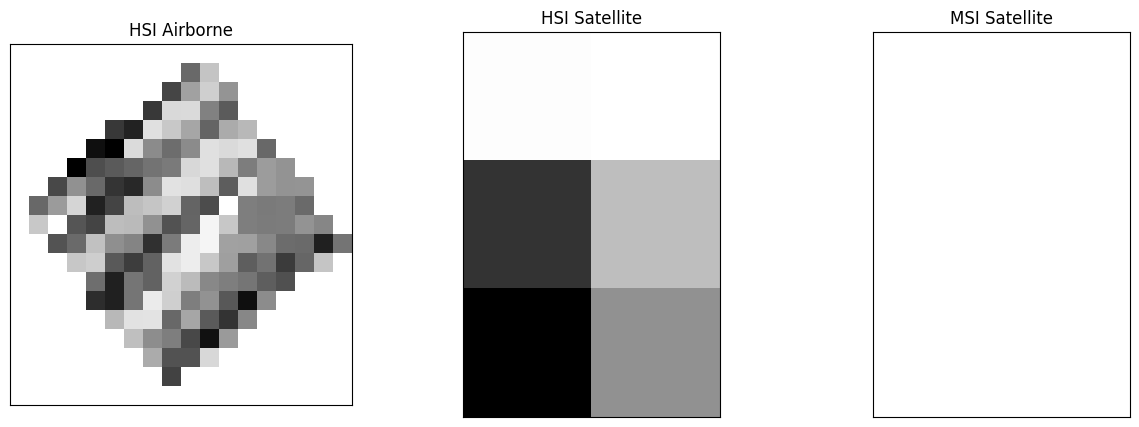

In [3]:
selected_index = 377
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
BAND_NUMBER = 7

# HSI airborne
with np.load(HSI_AIRBORNE_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    axs[0].imshow(arr[BAND_NUMBER, :, :], cmap='Greys')
    axs[0].set_title('HSI Airborne')
    axs[0].set_xticks([])
    axs[0].set_yticks([])


# HSI satellite
with np.load(HSI_SATELLITE_TRAIN_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    axs[1].imshow(arr[BAND_NUMBER, :, :].data, cmap='Greys',)
    axs[1].set_title('HSI Satellite')
    axs[1].set_xticks([])
    axs[1].set_yticks([])

# MSI satellite
with np.load(MSI_SATELLITE_TRAIN_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    axs[2].imshow(arr[BAND_NUMBER, :, :], cmap='Greys')
    axs[2].set_title('MSI Satellite')
    axs[2].set_xticks([])
    axs[2].set_yticks([])


# plt.title(f'Band: {BAND_NUMBER}')
plt.show()

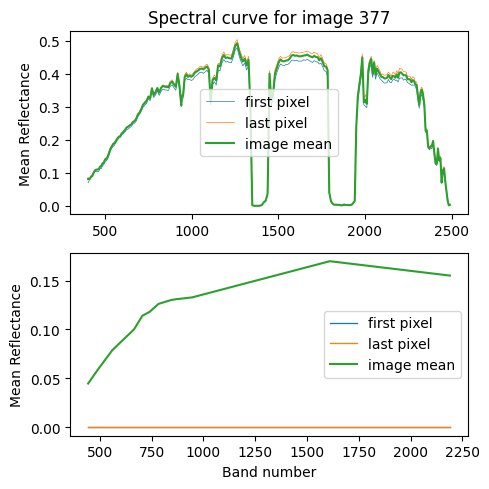

In [9]:
selected_index = 377

fig, ax = plt.subplots(2,1,figsize=(5,5))

with np.load(DATASET_DIR / 'train' / 'hsi_satellite' / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)


first_pixel  = arr.data[:,0,0]
last_pixel = arr.data[:,-1,-1]

ax[0].plot(wavelengths, first_pixel, linewidth=.5, label='first pixel')
ax[0].plot(wavelengths, last_pixel, linewidth=.5, label='last pixel')
ax[0].plot(wavelengths, arr.data.mean(axis=(1,2)), label='image mean')
# plt.legend()
ax[0].set_ylabel('Mean Reflectance')
ax[0].set_title(f'Spectral curve for image {selected_index}')
ax[0].legend()


with np.load(DATASET_DIR / 'train' / 'msi_satellite' / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    first_pixel  = arr.data[:,0,0]
    last_pixel = arr.data[:,-1,-1]

msi_waves = waves['msi_satellite_wavelengths'].values()
ax[1].plot(msi_waves, first_pixel, linewidth=.95, label='first pixel')
ax[1].plot(msi_waves, last_pixel, linewidth=.95, label='last pixel')
ax[1].plot(msi_waves, arr.data.mean(axis=(1,2)), label='image mean')
ax[1].legend()
ax[1].set_xlabel('Band number')
ax[1].set_ylabel('Mean Reflectance')

plt.tight_layout()

In [10]:
X_train_all, y_train_all, waves, y_names = load_data(
    # HSI_SATELLITE_TRAIN_DIR, 
    'hsi'
    )

print(f'X_train shape: {X_train_all.shape}')
print(f'Y_train shape: {y_train_all.shape}')

X_train shape: (1876, 230)
Y_train shape: (1876, 6)


<Axes: >

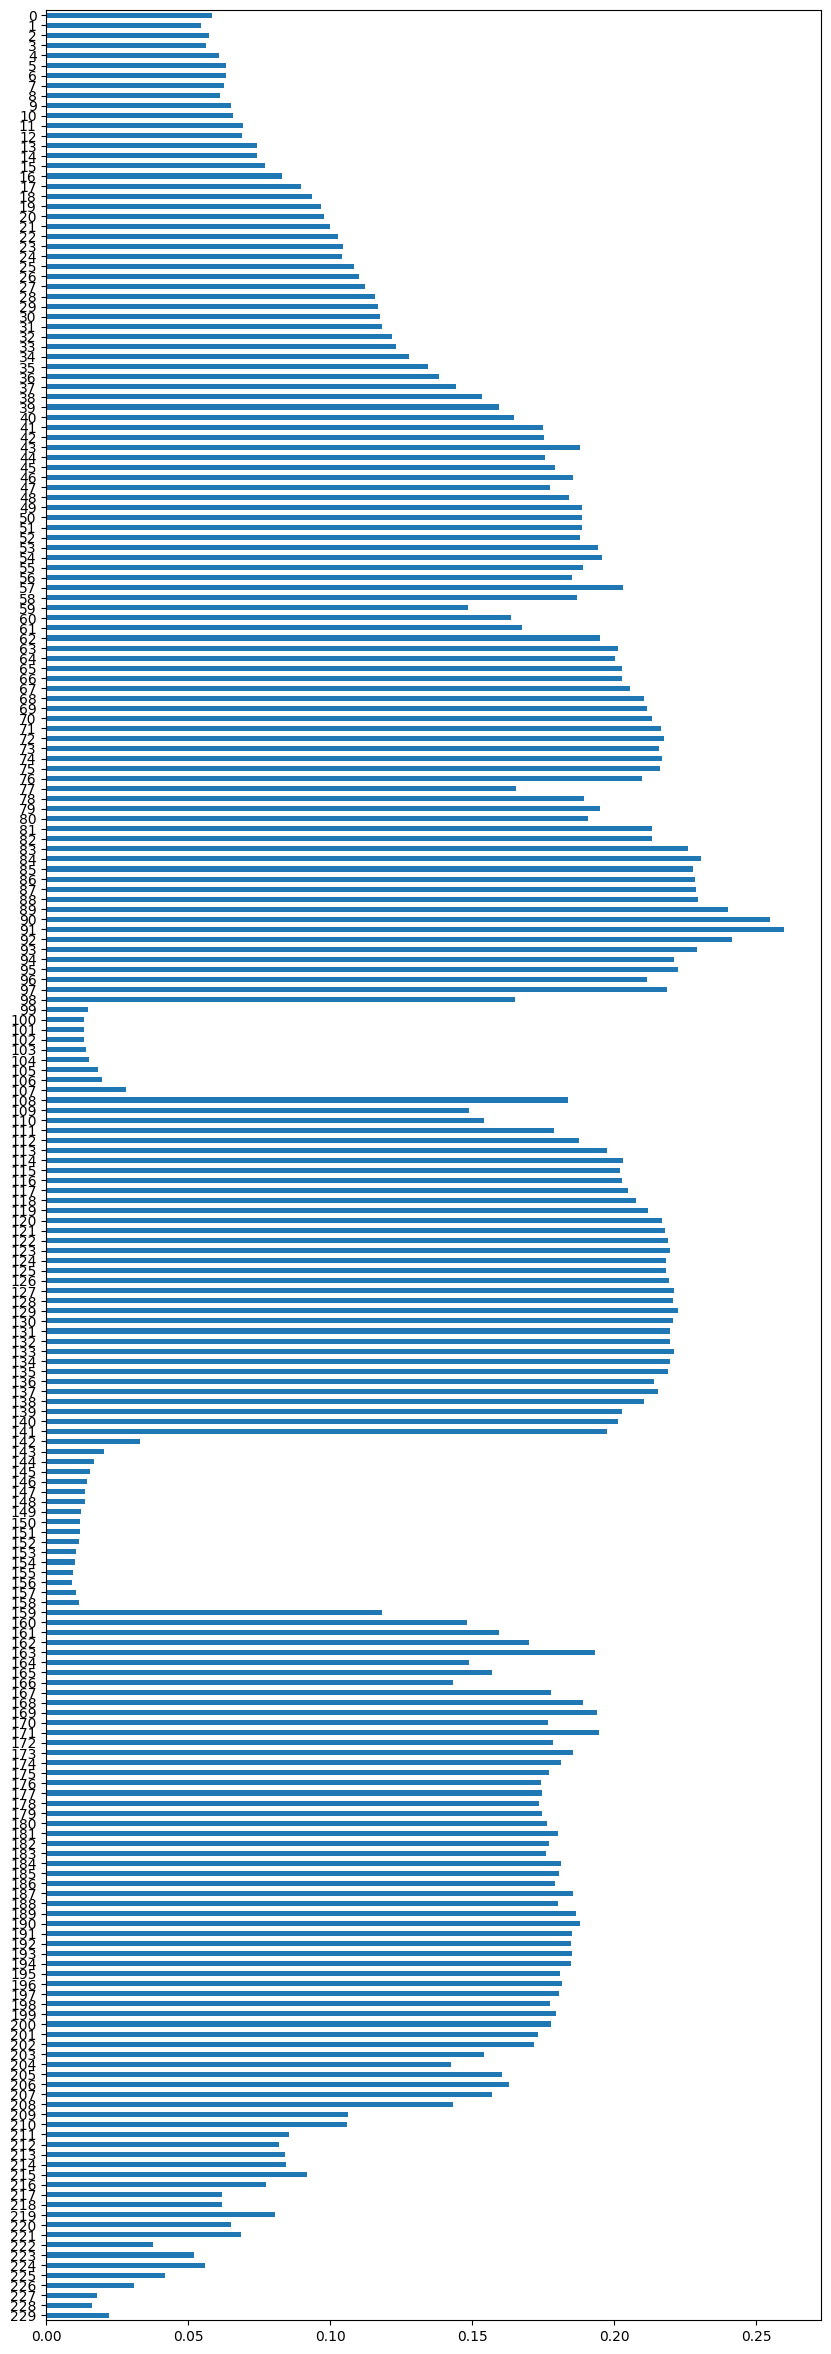

In [13]:
pd.DataFrame(X_train_all).describe().T.sort_index(ascending=False)['mean'].plot(kind='barh',figsize=(10, 30))

In [83]:
snr_std

402.44020     7.573063e-18
411.31638     4.165185e-17
419.37250     6.437104e-17
426.96744     2.177256e-17
434.30840     6.626430e-18
                  ...     
2462.81300    6.437104e-17
2469.41550    6.768425e-17
2476.79130    2.650572e-17
2483.59060    2.650572e-17
2490.02800    1.893266e-17
Length: 230, dtype: float64

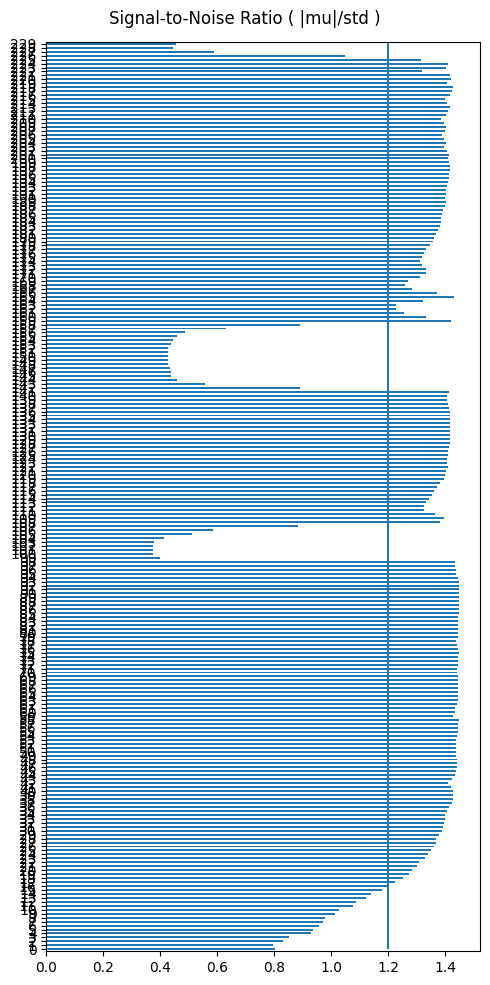

In [161]:
data_info = pd.DataFrame(
    X_train_all, 
    # columns=wavelengths
    ).describe().T
snr_raw = data_info['mean'].abs() / data_info['std']

fig, ax = plt.subplots(1,1, figsize=(5,10))
snr_raw.plot(kind='barh', ax=ax)
ax.vlines(x=[1.2], ymax=230, ymin=0)
fig.suptitle('Signal-to-Noise Ratio ( |mu|/std )')
plt.tight_layout()
plt.show()


In [159]:
thr = 1.3
bad_bands = snr_raw[ snr_raw < thr].index
snr_mask = snr_raw[ snr_raw >= thr].index

In [162]:
X_train_all_std = (X_train_all - np.mean(X_train_all, axis=0))/np.std(X_train_all, axis=0)
X_d0 = savgol_filter(
    X_train_all,
    window_length=11,
    polyorder=2,
    deriv=0,
    axis=1
    )

X_d1 = savgol_filter(
    X_train_all,
    window_length=11,
    polyorder=2,
    deriv=1,
    axis=1
    )

d_d0 = pd.DataFrame(X_d0, columns=wavelengths)
d_d1 = pd.DataFrame(X_d1, columns=wavelengths)

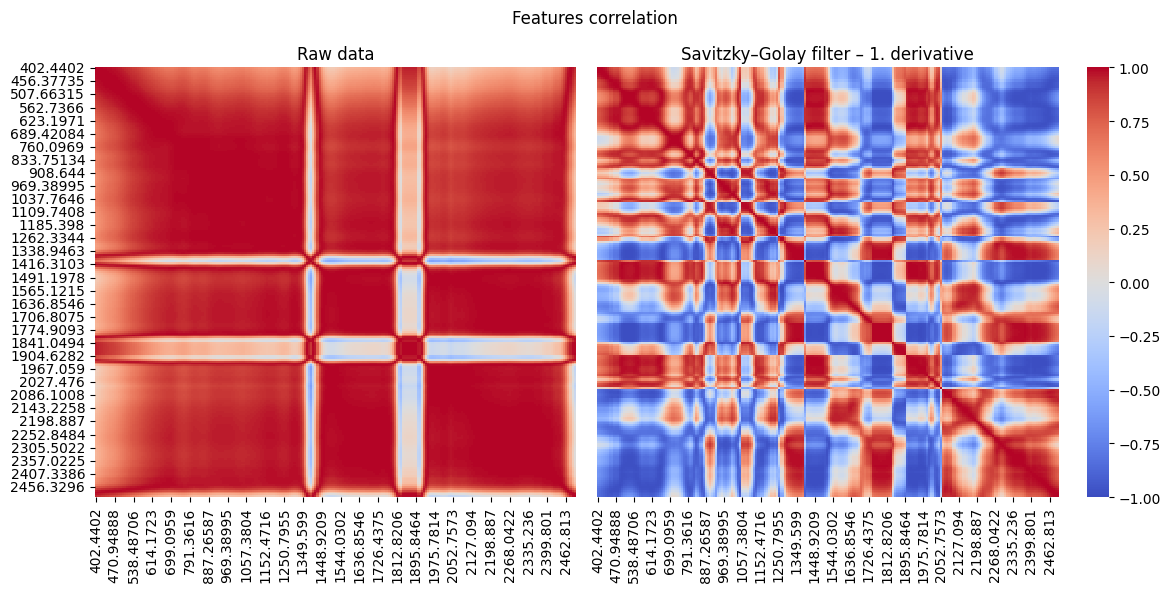

In [163]:
fig = plt.figure(figsize=(12,6))
gs = GridSpec(1, 2, width_ratios=[2.5,3]) 
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

sns.heatmap(d_d0.corr(),
    cmap='coolwarm',
    center=0,
    ax=ax1,
    vmin=-1, vmax=1,
    cbar=False,
)

sns.heatmap(d_d1.corr(),
    cmap='coolwarm',
    center=0,
    ax=ax2,
    yticklabels=False,
    vmin=-1, vmax=1,
)
ax1.set_title(f"Raw data")
ax2.set_title(f"Savitzky–Golay filter – 1. derivative")
fig.suptitle('Features correlation')
plt.tight_layout()
plt.show()


In [333]:
# PSL Regression

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X_d1[:, snr_mask], y_train_all, test_size=0.2, random_state=42
)

print(X_train.shape)
n_components = 8
pipeline = TransformedTargetRegressor(
    regressor=PLSRegression(
        n_components=n_components
        ),
    transformer=StandardScaler(),
)

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test  = pipeline.predict(X_test)

r2_train = [r2_score(y_train[:, i], y_pred_train[:, i]) for i in range(y_train.shape[1])]
r2_test  = [r2_score(y_test[:, i],  y_pred_test[:, i])  for i in range(y_train.shape[1])]

print("R² train per target:", r2_train)
print("R² test  per target:", r2_test)

mse_ = mean_squared_error(y_test, y_pred_test, multioutput='raw_values')
bl_mse = ((y_test - y_train.mean(axis=0))**2).mean(axis=0)

print("MSE test error:", mse_/bl_mse)

(1500, 172)
R² train per target: [0.20950884155667582, 0.14929416799184891, 0.24889802647549597, 0.13996880541576162, 0.23285400494936692, 0.21806996544273505]
R² test  per target: [0.17977494537904193, 0.06527264566069058, 0.24351986578426077, 0.12715433393632525, 0.25858379155643674, 0.2770893426981198]
MSE test error: [0.81741354 0.92483468 0.75317757 0.87276765 0.7414162  0.72245667]


In [167]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

class BandFilterSNR(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.keep_idx = None

    def fit(self, X, y=None):
        snr = np.abs(np.mean(X, axis=0)) / np.std(X, axis=0)
        self.keep_idx = np.where(snr > self.threshold)[0]
        return self

    def transform(self, X):
        return X[:, self.keep_idx]
    

class PLSFeatureExtractor(BaseEstimator, TransformerMixin):
    """Wyciąga składowe PLS jako cechy dla kolejnego estymatora."""
    def __init__(self, n_components=10):
        self.n_components = n_components
        self.pls = PLSRegression(n_components=self.n_components)

    def fit(self, X, y):
        # PLS potrzebuje Y do znalezienia kierunków kowariancji
        self.pls.fit(X, y)
        return self

    def transform(self, X):
        return self.pls.transform(X)

# 1. Definicja Pipeline dla Regresora (RF operujący na komponentach PLS)
rf_on_pls_pipeline = Pipeline([
    ('snr_filter', BandFilterSNR(threshold=1.25)),
    ('pls_features', PLSFeatureExtractor(n_components=12)),
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

# 2. Wrapujemy w TransformedTargetRegressor, aby automatycznie skalować Y
model = TransformedTargetRegressor(
    regressor=rf_on_pls_pipeline,
    transformer=StandardScaler()
)

In [168]:
X_train, X_test, y_train, y_test = train_test_split(
    X_d1, y_train_all, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

y_pred_test = predictions
mse_ = mean_squared_error(y_test, y_pred_test, multioutput='raw_values')
bl_mse = ((y_test - y_train.mean(axis=0))**2).mean(axis=0)

print("MSE test error:", mse_/bl_mse)

MSE test error: [0.69644759 0.77484926 0.6887022  0.77820779 0.75936141 0.65143104]


In [307]:
# testy stabilności modeli
# Cel

# Sprawdzić:

# czy model uczy się stabilnej struktury widma

# czy tylko „łapie szczęśliwe długości fal”
# To jest kluczowy test, bo:
# RF często ma niestabilne feature importance
# PLS ma stabilne loadings, jeśli struktura jest fizyczna

In [169]:
pls = PLSRegression(n_components=10)
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=0,
    n_jobs=-1
)

ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

pls_coefs = []
pls_vips = []
rf_perm_imps = []


def pls_vip(pls, X, y):
    """
    Compute VIP (Variable Importance in Projection) scores for fitted PLS model
    """
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_

    p, h = W.shape
    s = np.diag(T.T @ T @ Q.T @ Q).reshape(h, -1)
    total_s = np.sum(s)

    vip = np.sqrt(p * (W**2 @ s).ravel() / total_s)
    return vip

In [207]:
X_train, X_test, y_train, y_test = train_test_split(
    X_d1[:, snr_mask], y_train_all, test_size=0.2, random_state=42
)
print(X_train.shape)



class SavGolTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_length, polyorder, deriv):
        self.params = {
            'window_length': window_length,
            'polyorder': polyorder,
            'deriv': deriv,
        }
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return savgol_filter(X, **self.params)


pipeline = TransformedTargetRegressor(
    regressor=Pipeline([
    # ('snr_filter', BandFilterSNR(threshold=1.3)), # 1. Usuwamy szum
    ('savgol', SavGolTransformer(window_length=15, polyorder=2, deriv=1)), # 2. Wygładzamy i liczymy pochodną
    ("regressor", PLSRegression(n_components=12)), # 3. Model
]),
    transformer=StandardScaler(),
)

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test  = pipeline.predict(X_test)

r2_train = [r2_score(y_train[:, i], y_pred_train[:, i]) for i in range(y_train.shape[1])]
r2_test  = [r2_score(y_test[:, i],  y_pred_test[:, i])  for i in range(y_train.shape[1])]

mse_ = mean_squared_error(y_test, y_pred_test, multioutput='raw_values')
bl_mse = ((y_test - y_train.mean(axis=0))**2).mean(axis=0)

pd.DataFrame([
    r2_train,
    r2_test,
    mse_/bl_mse,
], columns=column_names, index=['r2_train', 'r2_test','mse'])

(1500, 172)


,Fe,Zn,B,Cu,S,Mn
r2_train,0.230234,0.162003,0.302719,0.116887,0.243339,0.250259
r2_test,0.192124,0.045569,0.259767,0.089004,0.258952,0.299140
mse,0.805107,0.944330,0.737002,0.910914,0.741048,0.700420


In [215]:
# coefs = model.regressor_.named_steps('rf').feature_selection
coefs = pipeline.regressor_.named_steps['regressor'].coef_

full_range = np.arange(len(wavelengths)) 
full_coefs_matrix = np.zeros((coefs.shape[0], len(full_range)))
full_coefs_matrix[:, snr_mask] = coefs
df_coefs = pd.DataFrame(full_coefs_matrix, columns=wavelengths, index=y_names)
df_coefs = df_coefs.T

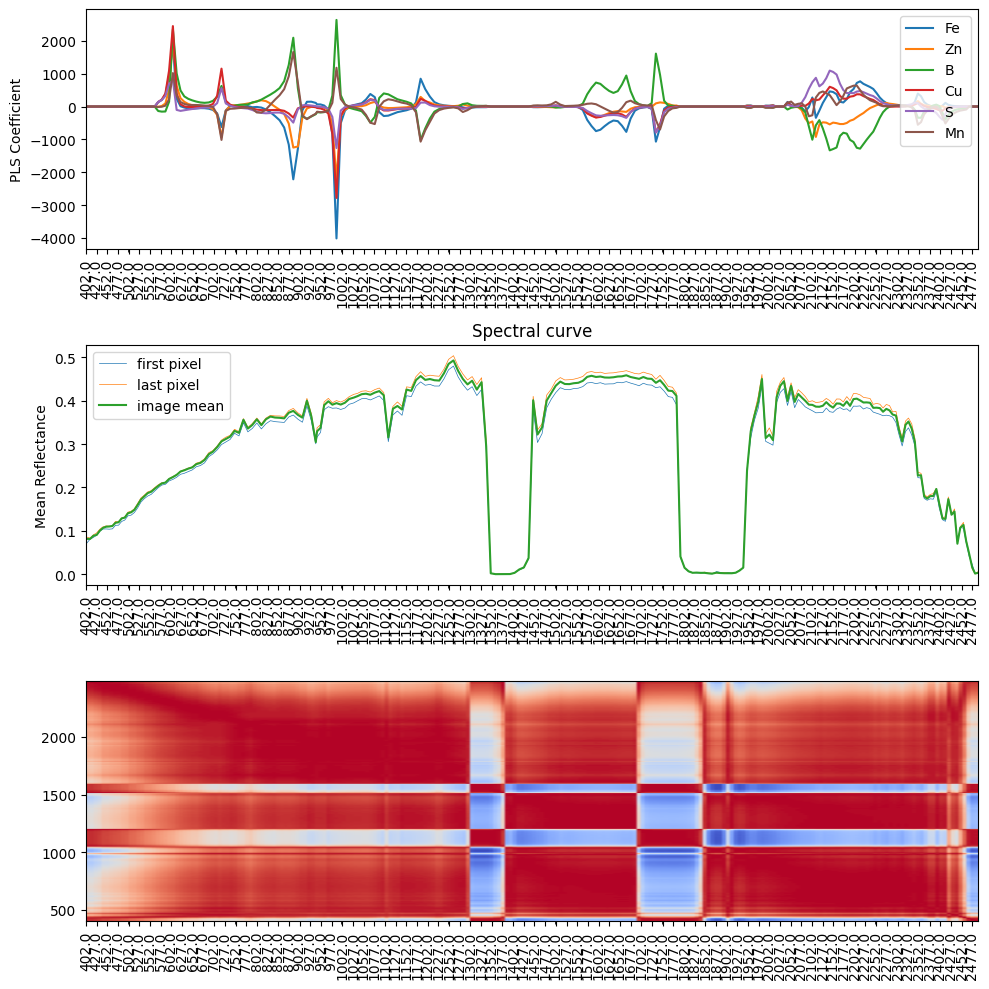

In [217]:
fig, ax = plt.subplots(3, 1, figsize=(10,10), sharex=True, )
df_coefs.plot(ax=ax[0])
ax[0].set_xlabel("Wavelength (nm)")
ax[0].set_ylabel("PLS Coefficient")
ax[0].legend(loc='upper right')
with np.load(DATASET_DIR / 'train' / 'hsi_satellite' / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)


first_pixel  = arr.data[:,0,0]
last_pixel = arr.data[:,-1,-1]

ax[1].plot(wavelengths, first_pixel, linewidth=.5, label='first pixel')
ax[1].plot(wavelengths, last_pixel, linewidth=.5, label='last pixel')
ax[1].plot(wavelengths, arr.data.mean(axis=(1,2)), label='image mean')
ax[1].set_xlabel('Wavelengths (nm)')
ax[1].set_ylabel('Mean Reflectance')
ax[1].set_title('Spectral curve')
ax[1].legend()

d = pd.DataFrame(X_train_all, columns=wavelengths)
extent = [
    np.min(wavelengths), np.max(wavelengths),
    np.min(wavelengths), np.max(wavelengths)
]

ax[2].imshow(d.corr(), extent=extent, aspect='auto', cmap='coolwarm')

step = 25
ticks = np.arange(np.min(wavelengths), np.max(wavelengths), step).round()

for axi in ax:
    axi.set_xlim(np.min(wavelengths), np.max(wavelengths))
    axi.set_xticks(ticks)
    axi.set_xticklabels(ticks, rotation=90)

    axi.tick_params(
        axis="x",
        which="both",
        labelbottom=True
    )

plt.legend
plt.tight_layout()
plt.show()


In [221]:
importance_per_target = np.sum(np.abs(coefs), axis=1)  # shape = (n_targets,)
for i, imp in enumerate(importance_per_target):
    print(f"{column_names[i]} predictive strength (sum |coef|): {imp:.3f}")

Fe predictive strength (sum |coef|): 42187.865
Zn predictive strength (sum |coef|): 28193.971
B predictive strength (sum |coef|): 58674.373
Cu predictive strength (sum |coef|): 26987.375
S predictive strength (sum |coef|): 30262.284
Mn predictive strength (sum |coef|): 33385.142
